## Analysis of the workflow lifetime and their distribution in each status
This notebook is used to parse workflows from ReqMgr2 (or directly from CouchDB) to better understand their lifetime and time distribution according to their statuses. It also groups workflows according to:
* their final status
* whether it is a recovery (ACDC) or a standard workflow (ReReco/TaskChain/StepChain)
* their input data requirements

NOTE-0: the vast majority of this analysis is based on workflows that ended in `normal-archived` status (normal status transition and announced to the collaboration) and RelVal workflows are not considered.

NOTE-1: a dump of the workflows used in this analysis can be found at: https://amaltaro.web.cern.ch/amaltaro/WMAnalytics/workflow_dump.json.gz . Keep in mind that you need to decompress it before loading it in this notebook. To decompress it, run: `gzip -d workflow_dump.json.gz` (compressed size=101MB, decompressed=3.1GB).

NOTE-2: there are a few imports scattered in the notebook, you might want to create a venv and install all those dependencies.

NOTE-3: the lines below define a user grid certificate, please override their values(!!!)

In [1]:
import os
import sys
import requests
import json
import statistics
from pprint import pprint
# needed for nice tables
from tabulate import tabulate
# needed for the histogram
import matplotlib.pyplot as plt
import numpy as np
# needed for the percentile plots
import warnings
warnings.simplefilter('ignore')
import seaborn
import probscale
clear_bkgd = {'axes.facecolor':'none', 'figure.facecolor':'none'}
seaborn.set(style='ticks', context='talk', color_codes=True, rc=clear_bkgd)

### UPDATE these lines below (this is the only place with hard-coded definitions in the notebook)

In [2]:
myCert = "/Users/amaltar2/Devel/DockerWMCore/certs/servicecert.pem"
myKey = "/Users/amaltar2/Devel/DockerWMCore/certs/servicekey.pem"

### We cannot retrieve archived workflows from ReqMgr2 - it is just too heavy! 
The alternative for that is to make an HTTP call directly to central CouchDB (DISCLAIMER: this can time out if your date range is too large, as it needs to transfer GB of data out of CouchDB).
Note that with the current query strings it will bring in 3.1GB of data.

In [47]:
%%time
couchUrl = "https://cmsweb.cern.ch/couchdb/reqmgr_workload_cache/_design/ReqMgr/_view/bydate"
queryParams = {"startkey": "[2022,4,1]", "endkey": "[2023,4,1]", "include_docs": True}
data = requests.get(couchUrl, params=queryParams, headers=headers, cert=(myCert, myKey), verify=False)
print(data)
if data.ok is True:
    data = data.json()['rows']
print(f"Total number of workflows: {len(data)}")

/Users/amaltar2/.virtualenvs/py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
Total number of workflows: 236810


### Optionally, you can simply load this data from the dump that Alan provides (make sure to first decompress workflow_dump.json.gz)

In [3]:
with open("workflow_dump.json", "r") as fo:
    data = json.load(fo)
print(f"Loaded a total of {len(data)} workflows.")

Loaded a total of 236810 workflows.


### If you want, dump this data as json to avoid querying CouchDB

In [48]:
#with open("workflow_dump.json", "w") as fo:
#    json.dump(data, fo, indent=2)

## Utilitarian functions to find whether a workflow requires primary or secondary data as input

In [4]:
## utilitarian function to check whether a workflow has or not input data
def hasInput(wf_dict):
    if wf_dict.get("InputDataset", ""):
        return True
    elif wf_dict.get("Task1", {}).get("InputDataset", ""):
        return True
    elif wf_dict.get("Step1", {}).get("InputDataset", ""):
        return True
    return False


## utilitarian function to check whether a workflow has or not input pileup data
def hasPileup(wf_dict):
    if wf_dict["RequestType"] == "TaskChain":
        for nTask in range(1, wf_dict["TaskChain"] + 1):
            tName = f"Task{nTask}"
            if wf_dict[tName].get("MCPileup", ""):
                return True
    elif wf_dict["RequestType"] == "StepChain":
        for nTask in range(1, wf_dict["StepChain"] + 1):
            tName = f"Step{nTask}"
            if wf_dict[tName].get("MCPileup", ""):
                return True
    return False

## Parse each document creating a timeline per campaign (note that RelVal workflows are disconsidered)
Definition of `Wallclocktime` here is the time elapsed between the workflow creation in ReqMgr2 (entered the `new` status) through the moment the workflow was finally archived (entered the `normal-archived` status, post announcement).

In [5]:
%%time
normal_wfs = []
rejected_wfs = []
aborted_wfs = []
others_wfs = []
relval_wfs = 0
for wflow in data:
    summary = {}
    if wflow["doc"].get("SubRequestType", "") in ['RelVal', 'HIRelVal']:
        relval_wfs += 1
        continue
    
    summary["RequestName"] = wflow["doc"]["RequestName"]
    summary["RequestType"] = wflow["doc"]["RequestType"]
    summary["RequestStatus"] = wflow["doc"]["RequestStatus"]
    summary["Campaign"] = wflow["doc"]["Campaign"]
    summary["HasInput"] = hasInput(wflow["doc"])
    summary["HasPileup"] = hasPileup(wflow["doc"])
    summary["StatusDuration"] = []
    summary["Wallclocktime"] = 0
    ## then parse status transition
    totalTransitions = len(wflow["doc"]["RequestTransition"])
    for idx, item in enumerate(wflow["doc"]["RequestTransition"]):
        if item["Status"] in ("normal-archived", "rejected-archived", "aborted-archived"):
            # then we are in the last transition (theoretically), grab the total workflow wallclocktime
            summary["Wallclocktime"] = item["UpdateTime"] - wflow["doc"]["RequestTransition"][0]["UpdateTime"]
        elif idx < totalTransitions - 1:
            # intermediate transitions, use the next step to calculate time duration
            thisTransition = {"Status": item["Status"]}
            thisTransition["DurationSecs"] = wflow["doc"]["RequestTransition"][idx + 1]["UpdateTime"] - item["UpdateTime"]
        summary["StatusDuration"].append(thisTransition)

    # now classify this workflow according to its current status
    if summary["RequestStatus"] == "normal-archived":
        normal_wfs.append(summary)
    elif summary["RequestStatus"] == "rejected-archived":
        rejected_wfs.append(summary)  
    elif summary["RequestStatus"] == "aborted-archived":
        aborted_wfs.append(summary)  
    else:
        others_wfs.append(summary)  
print(f"Total number of RelVal workflows: {relval_wfs}")

Total number of RelVal workflows: 7122
CPU times: user 1.42 s, sys: 1.57 s, total: 2.99 s
Wall time: 3.43 s


## Print number of workflows in each status
This provides a break down of the current status - or the moment the workflow json dump was created ~25/Jun/2023 - of all normal-archived workflows from 1/Apr/2022 through 1/Apr/2023.

Details for each workflow status can be found at: https://github.com/dmwm/WMCore/wiki/Request-Status

In [6]:
# while this object will contain final stats for workflows in a given status
columnNames = ["status", "num workflows"]
wflowStats = []
wflowStats.append(["normal-archived", len(normal_wfs)])
wflowStats.append(["rejected-archived", len(rejected_wfs)])
wflowStats.append(["aborted-archived", len(aborted_wfs)])
# now get numbers for the other statuses
dictStatuses = {}
for wflow in others_wfs:
    dictStatuses.setdefault(wflow["RequestStatus"], 0)
    dictStatuses[wflow["RequestStatus"]] += 1
    
for status, wflowCount in dictStatuses.items():
    wflowStats.append([status, wflowCount])

wflowStats.append(["TOTAL", len(normal_wfs) + len(rejected_wfs) + len(aborted_wfs) + len(others_wfs)])

#pprint(wflowStats)
print(tabulate(wflowStats, headers=columnNames, tablefmt="fancy_grid"))

╒═════════════════════╤═════════════════╕
│ status              │   num workflows │
╞═════════════════════╪═════════════════╡
│ normal-archived     │          147028 │
├─────────────────────┼─────────────────┤
│ rejected-archived   │           64943 │
├─────────────────────┼─────────────────┤
│ aborted-archived    │           15197 │
├─────────────────────┼─────────────────┤
│ announced           │            1719 │
├─────────────────────┼─────────────────┤
│ completed           │             239 │
├─────────────────────┼─────────────────┤
│ new                 │             368 │
├─────────────────────┼─────────────────┤
│ assignment-approved │              59 │
├─────────────────────┼─────────────────┤
│ failed              │             102 │
├─────────────────────┼─────────────────┤
│ staging             │               6 │
├─────────────────────┼─────────────────┤
│ acquired            │              11 │
├─────────────────────┼─────────────────┤
│ aborted             │           

## Get stats for workflows that reached the normal-archived status (mean, median, stddev)
Just a reminder that RelVals are not considered here, as well as workflows that have been rejected or aborted.

In [7]:
# while this object will contain final stats for workflows in a given status
columnNames = ["status", "mean (days)", "median (days)", "stdev (days)"]
wflowStats = {}
daySecs = 24 * 3600
for wf in normal_wfs:
    wflowStats.setdefault("normal-archived", [])
    wflowStats["normal-archived"].append(wf["Wallclocktime"])
for wf in aborted_wfs:
    wflowStats.setdefault("aborted-archived", [])
    wflowStats["aborted-archived"].append(wf["Wallclocktime"])

# variable to keep the number of workflows that was rejected after running in the grid
# new -> assignment-approved -> assigned -> staging -> staged -> acquired -> running-open -> running-closed
# completed -> ?rejected
lateRejection = 0
for wf in rejected_wfs:
    wflowStats.setdefault("rejected-archived", [])
    wflowStats["rejected-archived"].append(wf["Wallclocktime"])
    if len(wf["StatusDuration"]) > 8:
        lateRejection += 1
print(f"Found a total of {lateRejection} workflows rejected after running in the grid resources")

# now calculte mean, median and std deviation
results = []
for status, values in wflowStats.items():
    thisStats = []
    thisStats.append(status)
    thisStats.append(round(statistics.mean(values) / daySecs, 2))
    thisStats.append(round(statistics.median(values) / daySecs, 2))
    thisStats.append(round(statistics.stdev(values) / daySecs, 2))
    results.append(thisStats)

#pprint(wflowStats)
print(tabulate(results, headers=columnNames, tablefmt="fancy_grid"))

Found a total of 3112 workflows rejected after running in the grid resources
╒═══════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status            │   mean (days) │   median (days) │   stdev (days) │
╞═══════════════════╪═══════════════╪═════════════════╪════════════════╡
│ normal-archived   │         37.85 │           14.37 │          43.51 │
├───────────────────┼───────────────┼─────────────────┼────────────────┤
│ aborted-archived  │         12.27 │            3.31 │          21.55 │
├───────────────────┼───────────────┼─────────────────┼────────────────┤
│ rejected-archived │          6.17 │            2.75 │          16.62 │
╘═══════════════════╧═══════════════╧═════════════════╧════════════════╛


## This gives stats for standard vs ACDC/Recovery workflows
Note that one standard workflow can have 0..N recovery workflows.

In [8]:
wflowStats = {}
for wf in normal_wfs:
    if wf['RequestType'] == 'Resubmission':
            wflowStats.setdefault("**recovery normal", [])
            wflowStats["**recovery normal"].append(wf["Wallclocktime"])
    else:
        wflowStats.setdefault("**standard normal", [])
        wflowStats["**standard normal"].append(wf["Wallclocktime"])
print(f"Standard workflows that reached normal-archived: {len(wflowStats['**standard normal'])}")
print(f"Recovery workflows that reached normal-archived: {len(wflowStats['**recovery normal'])}")

# now calculte mean, median and std deviation
results = []
for status, values in wflowStats.items():
    thisStats = []
    thisStats.append(status)
    thisStats.append(round(statistics.mean(values) / daySecs, 2))
    thisStats.append(round(statistics.median(values) / daySecs, 2))
    thisStats.append(round(statistics.stdev(values) / daySecs, 2))
    results.append(thisStats)

#pprint(wflowStats)
print(tabulate(results, headers=columnNames, tablefmt="fancy_grid"))

Standard workflows that reached normal-archived: 125838
Recovery workflows that reached normal-archived: 21190
╒═══════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status            │   mean (days) │   median (days) │   stdev (days) │
╞═══════════════════╪═══════════════╪═════════════════╪════════════════╡
│ **recovery normal │         16.36 │            7.12 │          28.35 │
├───────────────────┼───────────────┼─────────────────┼────────────────┤
│ **standard normal │         41.46 │           17.91 │          44.56 │
╘═══════════════════╧═══════════════╧═════════════════╧════════════════╛


## Grab some status-based statistics for the normal-archived workflows (mean, median, stddev)
The table belows provides those stats for each status of a workflow. In other words, how long workflows spent in each status. Some important background information can be:
* from `new` to `assignment-approved`: this is in the hands of PdmV, while they decide whether a workflow can be approved to central production or not.
* from `assignment-approved` to `assigned`: this is in the hands of P&R, controlling the amount of workflows that can be assigned and potentially sorting out campaign configurations and so on.
* `staging`: once it reaches this status, we assume that a) there is no input; or b) input data is already in place; or c) that all the relevant Rucio rules have been created
* `staged`: it reaches this status when Rucio rules for the input data has been satisfied.
* `acquired`: when the workqueue elements are created, i.e. chunks of work become available for the (WM)agents.
* `running-open` and `running-closed`: moment between the first job created in an agent until the last one finishes.
* `completed`: once all workqueue elements are done and all jobs completed (excluding LogCollect and Cleanup)
* `closed-out`: means that the workflow has reached enough stats and will soon get announced
* `announced`: workflows will remain in this status as long as the output tape rules are not satisfied and/or there is stepchain parentage data to be fixed in DBS (it could be missing a configuration in Unified and/or in the campaign as well)

In [9]:
ACTIVE_STATUS = ["new",
                 "assignment-approved",
                 "assigned",
                 "staging",
                 "staged",
                 "acquired",
                 "running-open",
                 "running-closed",
                 "force-complete",
                 "completed",
                 "closed-out",
                 "announced"]

# this object will contain all the absolute values for each workflow in each state
wflowValues = {}
for status in ACTIVE_STATUS:
    wflowValues[status] = []
for wflow in normal_wfs:
    for statusDict in wflow["StatusDuration"]:
        try:
            wflowValues[statusDict["Status"]].append(statusDict["DurationSecs"])
        except KeyError:
            print(f"Workflow {wflow['RequestName']} has an invalid status: {statusDict['Status']}")

Workflow pdmvserv_task_SMP-RunIISummer20UL16wmLHEGENAPV-00395__v1_T_220402_125734_9831 has an invalid status: rejected
Workflow haozturk_task_HIG-RunIISummer20UL16wmLHEGENAPV-03899__v1_T_220601_172532_7089 has an invalid status: rejected
Workflow pdmvserv_task_HIG-RunIISummer20UL16wmLHEGEN-06204__v1_T_220607_111555_5126 has an invalid status: rejected
Workflow pdmvserv_task_EXO-Run3Summer22wmLHEGS-00766__v1_T_230109_113601_2471 has an invalid status: rejected


In [10]:
# while this object will contain final stats for workflows in a given status
wflowStats = []
daySecs = 24 * 3600
for status in wflowValues:
    thisStats = []
    thisStats.append(status)
    thisStats.append(round(statistics.mean(wflowValues[status]) / daySecs, 2))
    thisStats.append(round(statistics.median(wflowValues[status]) / daySecs, 2))
    thisStats.append(round(statistics.stdev(wflowValues[status]) / daySecs, 2))
    wflowStats.append(thisStats)

columnNames = ["status", "mean (days)", "median (days)", "stdev (days)"]
print(tabulate(wflowStats, headers=columnNames, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status              │   mean (days) │   median (days) │   stdev (days) │
╞═════════════════════╪═══════════════╪═════════════════╪════════════════╡
│ new                 │          0.77 │            0    │           1.71 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ assignment-approved │         10.59 │            0.06 │          24.74 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ assigned            │          0.01 │            0    │           0.15 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ staging             │          0.87 │            0.04 │           3.36 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ staged              │          0.02 │            0.01 │           0.11 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ acquired            │  

## Create histogram for the workflow lifetime distribution
Considering only workflows that reached the normal-archived status

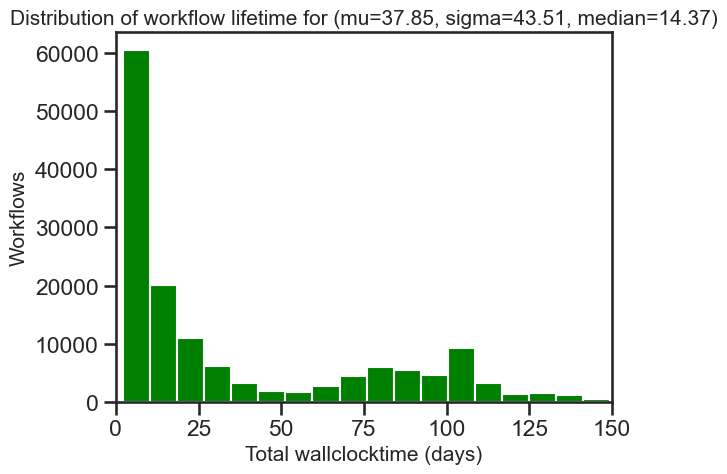

In [11]:
norm_values = [wf["Wallclocktime"] for wf in normal_wfs]
norm_values_days = [round(totalSecs / daySecs, 2) for totalSecs in norm_values]

mu_secs = round(statistics.mean(norm_values), 2)
sigma_secs = round(statistics.stdev(norm_values), 2)
mu_days = round(mu_secs / daySecs, 2)
sigma_days = round(sigma_secs / daySecs, 2)
median_days = round(statistics.median(norm_values) / daySecs, 2)

# Creating histogram
fig, ax = plt.subplots()
ax.hist(norm_values_days, bins=50, color ='green')
plt.xlim(0, 150) 
plt.title(f'Distribution of workflow lifetime for (mu={mu_days}, sigma={sigma_days}, median={median_days})', fontsize='15')
plt.xlabel('Total wallclocktime (days)', fontsize='15')
plt.ylabel('Workflows', fontsize='15')

# Show plot
plt.show()

In [12]:
# calculate rate of workflows within a given sigma
print(f"Overall normal-archived workflows with mean: {mu_days}, stddev: {sigma_days}, median: {median_days}")
for i in range(4):
    sigma = mu_days + (i * sigma_days)
    within_sigma = [item for item in norm_values_days if item <= sigma]
    print(f"  Rate of workflows within {i} sigma: {round(len(within_sigma)/len(norm_values_days), 3)}")

Overall normal-archived workflows with mean: 37.85, stddev: 43.51, median: 14.37
  Rate of workflows within 0 sigma: 0.674
  Rate of workflows within 1 sigma: 0.793
  Rate of workflows within 2 sigma: 0.966
  Rate of workflows within 3 sigma: 0.991


## Trying a percentile plot for normal-archived workflows, also expanding them to standard vs recovery workflows.
Source code reference: https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html

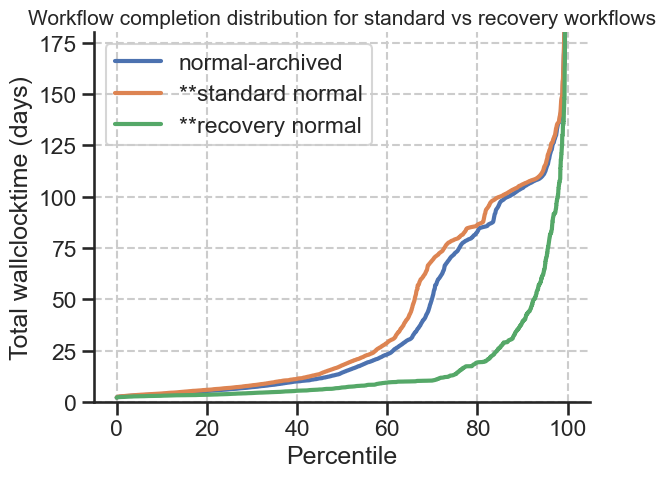

In [14]:
wflowStats = {}
for wf in normal_wfs:
    wflowStats.setdefault("normal-archived", [])
    wflowStats["normal-archived"].append(round(wf["Wallclocktime"] / daySecs, 2))
    if wf['RequestType'] == 'Resubmission':
            wflowStats.setdefault("**recovery normal", [])
            wflowStats["**recovery normal"].append(round(wf["Wallclocktime"] / daySecs, 2))
    else:
        wflowStats.setdefault("**standard normal", [])
        wflowStats["**standard normal"].append(round(wf["Wallclocktime"] / daySecs, 2))

position, days = probscale.plot_pos(wflowStats["normal-archived"])
position *= 100
fig, ax = plt.subplots()
ax.plot(position, days, linewidth=3, label='normal-archived')
#ax.plot(position, days, marker='.', linewidth=1, label='normal-archived')

position, days = probscale.plot_pos(wflowStats["**standard normal"])
position *= 100
ax.plot(position, days, linewidth=3, label='**standard normal')

position, days = probscale.plot_pos(wflowStats["**recovery normal"])
position *= 100
ax.plot(position, days, linewidth=3, label='**recovery normal')

plt.grid(visible=True, which='major', axis='both', linestyle='--')
plt.title(f'Workflow completion distribution for standard vs recovery workflows', fontsize='15')
ax.set_xlabel('Percentile')
ax.set_ylabel('Total wallclocktime (days)')
ax.set_ylim(bottom=0, top=180)
ax.legend()
seaborn.despine()

In [15]:
# calculate rate of workflows within a given sigma
mu_days = round(statistics.mean(wflowStats["**standard normal"]), 2)
sigma_days = round(statistics.stdev(wflowStats["**standard normal"]), 2)
median_days = round(statistics.median(wflowStats["**standard normal"]), 2)
wfs_sigma = []
print(f"Overall standard normal workflows with mean: {mu_days}, stddev: {sigma_days}, median: {median_days}")
for i in range(4):
    sigma = mu_days + (i * sigma_days)
    within_sigma = [item for item in wflowStats["**standard normal"] if item <= sigma]
    print(f"  Rate of workflows within {i} sigma: {round(len(within_sigma)/len(wflowStats['**standard normal']), 3)}")

# calculate rate of workflows within a given sigma
mu_days = round(statistics.mean(wflowStats["**recovery normal"]), 2)
sigma_days = round(statistics.stdev(wflowStats["**recovery normal"]), 2)
median_days = round(statistics.median(wflowStats["**recovery normal"]), 2)
wfs_sigma = []
print(f"\nOverall recovery normal workflows with mean: {mu_days}, stddev: {sigma_days}, median: {median_days}")
for i in range(4):
    sigma = mu_days + (i * sigma_days)
    within_sigma = [item for item in wflowStats["**recovery normal"] if item <= sigma]
    print(f"  Rate of workflows within {i} sigma: {round(len(within_sigma)/len(wflowStats['**recovery normal']), 3)}")

Overall standard normal workflows with mean: 41.46, stddev: 44.56, median: 17.91
  Rate of workflows within 0 sigma: 0.647
  Rate of workflows within 1 sigma: 0.799
  Rate of workflows within 2 sigma: 0.972
  Rate of workflows within 3 sigma: 0.992

Overall recovery normal workflows with mean: 16.36, stddev: 28.35, median: 7.12
  Rate of workflows within 0 sigma: 0.767
  Rate of workflows within 1 sigma: 0.917
  Rate of workflows within 2 sigma: 0.955
  Rate of workflows within 3 sigma: 0.979


# Classify and get stats for normal-archived workflows with input, secondary or not input at all
Definition for the 4 groups is:
1) `mc`: workflows with no input data at all (example, LHE, GEN-only, or all the way from GEN to Mini/NanoAODSIM)

2) `primary`: workflows with only primary data (e.g. ReReco, DR, etc)

3) `secondary`: workflows with only secondary data

4) `primary+secondary`: workflows with both primary and secondary data.


In [16]:
inputStats = {}
for wf in normal_wfs:
    if wf["HasInput"] is False and wf["HasPileup"] is False:
        inputStats.setdefault("mc", [])
        inputStats["mc"].append(wf["Wallclocktime"])
    elif wf["HasInput"] is True and wf["HasPileup"] is False:
        inputStats.setdefault("primary", [])
        inputStats["primary"].append(wf["Wallclocktime"])
    elif wf["HasInput"] is False and wf["HasPileup"] is True:
        inputStats.setdefault("secondary", [])
        inputStats["secondary"].append(wf["Wallclocktime"])
    elif wf["HasInput"] is True and wf["HasPileup"] is True:
        inputStats.setdefault("primary+secondary", [])
        inputStats["primary+secondary"].append(wf["Wallclocktime"])
    else:
        print(f"Should not be here!")


# now calculte mean, median and std deviation
results = []
daySecs = 24 * 3600
for status, values in inputStats.items():
    thisStats = []
    thisStats.append(status)
    thisStats.append(len(values))
    thisStats.append(round(statistics.mean(values) / daySecs, 2))
    thisStats.append(round(statistics.median(values) / daySecs, 2))
    thisStats.append(round(statistics.stdev(values) / daySecs, 2))
    results.append(thisStats)

# while this object will contain final stats for workflows in a given status
columnNames = ["status", "num workflows", "mean (days)", "median (days)", "stdev (days)"]
print(tabulate(results, headers=columnNames, tablefmt="fancy_grid"))

╒═══════════════════╤═════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status            │   num workflows │   mean (days) │   median (days) │   stdev (days) │
╞═══════════════════╪═════════════════╪═══════════════╪═════════════════╪════════════════╡
│ mc                │           18123 │         15.14 │            6.94 │          27.45 │
├───────────────────┼─────────────────┼───────────────┼─────────────────┼────────────────┤
│ primary           │           66999 │         12.75 │            8.31 │          14.77 │
├───────────────────┼─────────────────┼───────────────┼─────────────────┼────────────────┤
│ secondary         │           61711 │         71.83 │           79.42 │          45.37 │
├───────────────────┼─────────────────┼───────────────┼─────────────────┼────────────────┤
│ primary+secondary │             195 │         18.14 │           12.77 │          29.02 │
╘═══════════════════╧═════════════════╧═══════════════╧═════════════════╧════════════════╛

In [17]:
# calculate rate of workflows within a given sigma
for dType, wall_secs in inputStats.items():
    mu_secs = round(statistics.mean(wall_secs), 2)
    sigma_secs = round(statistics.stdev(wall_secs), 2)
    mu_days = round(mu_secs / daySecs, 2)
    sigma_days = round(sigma_secs / daySecs, 2)
    median_days = round(statistics.median(wall_secs) / daySecs, 2)
    wfs_sigma = []
    print(f"\nnormal-archived workflows with data type: {dType}, mean: {mu_days}, stddev: {sigma_days}, median: {median_days}")
    for i in range(4):
        sigma = mu_secs + (i * sigma_secs)
        within_sigma = [item for item in wall_secs if item <= sigma]
        print(f"  Rate of workflows within {i} sigma: {round(len(within_sigma)/len(wall_secs), 3)}")


normal-archived workflows with data type: mc, mean: 15.14, stddev: 27.45, median: 6.94
  Rate of workflows within 0 sigma: 0.786
  Rate of workflows within 1 sigma: 0.929
  Rate of workflows within 2 sigma: 0.96
  Rate of workflows within 3 sigma: 0.977

normal-archived workflows with data type: primary, mean: 12.75, stddev: 14.77, median: 8.31
  Rate of workflows within 0 sigma: 0.696
  Rate of workflows within 1 sigma: 0.909
  Rate of workflows within 2 sigma: 0.975
  Rate of workflows within 3 sigma: 0.986

normal-archived workflows with data type: secondary, mean: 71.83, stddev: 45.37, median: 79.42
  Rate of workflows within 0 sigma: 0.422
  Rate of workflows within 1 sigma: 0.906
  Rate of workflows within 2 sigma: 0.981
  Rate of workflows within 3 sigma: 0.99

normal-archived workflows with data type: primary+secondary, mean: 18.14, stddev: 29.02, median: 12.77
  Rate of workflows within 0 sigma: 0.703
  Rate of workflows within 1 sigma: 0.938
  Rate of workflows within 2 sigm

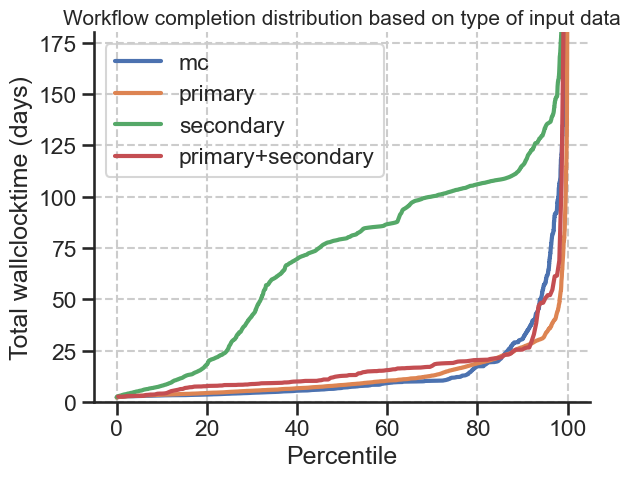

In [19]:
input_stats_days = {}
for dType, wall_secs in inputStats.items():
    input_stats_days.setdefault(dType, [])
    input_stats_days[dType] = [round(item / daySecs, 2) for item in wall_secs]

fig, ax = plt.subplots()

for dType, wall_days in input_stats_days.items():
    position, days = probscale.plot_pos(wall_days)
    position *= 100
    ax.plot(position, days, linewidth=3, label=dType)

plt.grid(visible=True, which='major', axis='both', linestyle='--')
plt.title(f'Workflow completion distribution based on type of input data', fontsize='15')
ax.set_xlabel('Percentile')
ax.set_ylabel('Total wallclocktime (days)')
ax.set_ylim(bottom=0, top=180)
ax.legend()
seaborn.despine()